# Youtube comments Clustering

Read the comments.csv to pandas dataframe.

In [1]:
import pandas as pd

df = pd.read_csv('../data/comments_labeled.csv', header=0)
df = df[df['text'].str.len() > 50]
len(df)

71262

Preprocessing the comments.

In [2]:
import string
from tqdm import tqdm

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer  # module for tokenizing strings

tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
stopwords_english = stopwords.words('english')
stemmer = PorterStemmer()

comments_clean = []
for text in tqdm(df['text']):
    token = tokenizer.tokenize(text)
    cleaned = []
    for word in token:
        if word not in stopwords_english and  word not in string.punctuation:
            cleaned.append(stemmer.stem(word))
    comments_clean.append(' '.join(cleaned))

print(comments_clean[:10])
df['text'] = comments_clean

100%|██████████| 71262/71262 [00:24<00:00, 2957.26it/s]

['1:31 make attack go secur layer first laugh norton mcafe guardio window defend', '3.5 billion dollar pathet modern chip build factori intel would need invest 10x drown money day easier keep suppli low better profit', 'imagin peopl fight facebook spi give even info googl appl', "facebook 1 month it'd chang everyth better think", 'techlink entir video dedic learn epic appl trial finish mayb full recap', 'moment facebook start demand money servic day fb start die spectacularli', 'techlink might follow concern spectr intel said one mention mitig follow protocol establish back 2018 first spectr meltdown debacl came per intel mitig step necessari', 'henc longer fb platform', 'present got fatter.h get old get shape dude youth calori burner machin dont last forev last leg', 'would pay subscript facebook pay us decad harvest data sell highest bidder lol']


First we use CountVectorizer to convert the text.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer(input='content', stop_words='english', min_df=0.01, max_df=0.8)
dtm_cv = cv.fit_transform(df['text'])
print(len(cv.get_feature_names()))

172


We train KMeans model with n_cluster=2:6.

In [4]:
import time
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

models = []
for i in range(2, 7):
    t = time.time()
    model = KMeans(n_clusters=i, random_state=501)
    model.fit(dtm_cv)
    models.append((i, model))
    print(f'Fitted KMeans({i}), time elapsed: {time.time() - t:.2f}s.')

Fitted KMeans(2), time elapsed: 10.85s.
Fitted KMeans(3), time elapsed: 29.16s.
Fitted KMeans(4), time elapsed: 36.87s.
Fitted KMeans(5), time elapsed: 49.64s.
Fitted KMeans(6), time elapsed: 45.74s.


Plot the sum of square distances for each model.

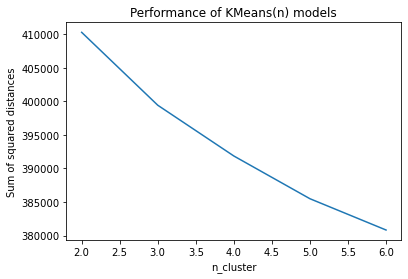

In [5]:
from matplotlib import pyplot as plt

plt.plot([m[0] for m in models], [m[1].inertia_ for m in models])
plt.xlabel('n_cluster')
plt.ylabel('Sum of squared distances')
plt.title('Performance of KMeans(n) models')
plt.show()

Print Top20 words in each cluster.

In [6]:
m = models[-1][1]
for i in range(m.n_clusters):
    center = m.cluster_centers_[i].argsort()[::-1]
    top20 = [cv.get_feature_names()[idx] for idx in center[:20]]
    print('\t', f'Cluster{i}: ', ','.join(top20))

	 Cluster0:  video,watch,linu,like,ad,make,guy,riley,youtub,time,good,tech,love,anthoni,use,know,got,realli,techlink,channel
	 Cluster1:  game,play,pc,like,use,make,buy,want,consol,peopl,gpu,card,new,xbox,need,run,good,time,year,realli
	 Cluster2:  like,look,make,use,peopl,linu,sound,realli,riley,know,time,thing,new,good,feel,say,want,guy,appl,tech
	 Cluster3:  dont,card,new,youtub,game,graphic,gpu,got,googl,good,gonna,funni,guess,fuck,free,final,feel,facebook,everyth,everyon
	 Cluster4:  amd,intel,nvidia,cpu,gpu,card,make,new,use,like,buy,price,year,better,ryzen,perform,time,peopl,good,chip
	 Cluster5:  linu,use,make,riley,time,peopl,know,good,new,want,tech,need,buy,news,say,think,guy,realli,love,appl


Then we use CountVectorizer(min_df=0.01, max_df=0.8, max_feature=100) to convert the text.

In [7]:
cv_100 = TfidfVectorizer(input='content', use_idf=False, min_df=0.01, max_df=0.8, max_features=100, stop_words='english')
dtm_cv_100 = cv_100.fit_transform(df['text'])
print(len(cv_100.get_feature_names()))

100


We train KMeans model with n_cluster=2:6 using dtm_cv_100 again.

In [8]:
models_100 = []
for i in range(2, 7):
    t = time.time()
    model = KMeans(n_clusters=i, random_state=501)
    model.fit(dtm_cv_100)
    models_100.append((i, model))
    print(f'Fitted KMeans({i}), time elapsed: {time.time() - t:.2f}s.')

Fitted KMeans(2), time elapsed: 14.23s.
Fitted KMeans(3), time elapsed: 37.22s.
Fitted KMeans(4), time elapsed: 35.36s.
Fitted KMeans(5), time elapsed: 38.65s.
Fitted KMeans(6), time elapsed: 32.19s.


Plot the sum of square distances for each model.

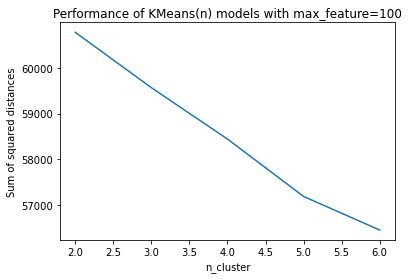

In [9]:
from matplotlib import pyplot as plt

plt.plot([m[0] for m in models_100], [m[1].inertia_ for m in models_100])
plt.xlabel('n_cluster')
plt.ylabel('Sum of squared distances')
plt.title('Performance of KMeans(n) models with max_feature=100')
plt.show()

Print Top20 words in each cluster.

In [10]:
m = models_100[-1][1]
for i in range(m.n_clusters):
    center = m.cluster_centers_[i].argsort()[::-1]
    top20 = [cv_100.get_feature_names()[idx] for idx in center[:20]]
    print('\t', f'Cluster{i}: ', ','.join(top20))

	 Cluster0:  use,video,game,riley,time,peopl,good,know,new,want,buy,need,say,guy,watch,card,think,love,nvidia,realli
	 Cluster1:  like,look,sound,video,linu,riley,use,realli,game,feel,peopl,guy,time,good,new,know,thing,say,want,think
	 Cluster2:  linu,video,ad,riley,got,know,watch,say,time,madison,love,guy,look,channel,tech,need,lol,good,think,new
	 Cluster3:  amd,intel,nvidia,cpu,gpu,new,card,use,buy,year,better,good,price,time,game,want,like,think,wait,come
	 Cluster4:  make,like,video,use,game,nvidia,peopl,card,gpu,money,want,need,good,think,time,new,know,realli,appl,buy
	 Cluster5:  news,tech,riley,video,watch,love,guy,channel,know,good,like,want,time,techlink,new,need,host,best,realli,pleas


Use TruncatedSVD to decompose dtm to 2-dimensional and then visualize the clusters.

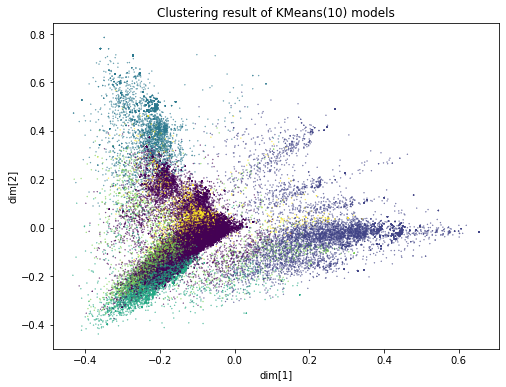

In [11]:
from sklearn.decomposition import TruncatedSVD

decomp = TruncatedSVD(n_components=3, random_state=501)
dtm_tfv_100_2d = decomp.fit_transform(dtm_cv_100)
plt.figure(figsize=(8,6))
plt.scatter(dtm_tfv_100_2d[:, 1], dtm_tfv_100_2d[:, 2], s=0.11, c=models_100[-1][1].labels_)
plt.xlabel('dim[1]')
plt.ylabel('dim[2]')
plt.title('Clustering result of KMeans(10) models')
plt.show()

The clustering results look good. We try the TfidfVectorizer instead of CountVectorizer.

In [12]:
tfv_100 = TfidfVectorizer(input='content', min_df=0.01, max_df=0.8, max_features=100, stop_words='english')
dtm_tfv_100 = tfv_100.fit_transform(df['text'])
print(tfv_100.get_feature_names()[50:100])

['new', 'news', 'nvidia', 'oh', 'old', 'pay', 'pc', 'peopl', 'phone', 'play', 'pleas', 'power', 'price', 'product', 'realli', 'releas', 'right', 'riley', 'rtx', 'run', 'said', 'say', 'sell', 'seri', 'shit', 'sinc', 'someth', 'sound', 'start', 'stop', 'support', 'sure', 'talk', 'tech', 'techlink', 'thank', 'thing', 'think', 'time', 'tri', 'use', 'video', 'wait', 'want', 'watch', 'way', 'work', 'xbox', 'year', 'youtub']


We train KMeans model with n_cluster=2:6 using dtm_cv_100 again.

In [13]:
models_tf_100 = []
for i in range(2, 7):
    t = time.time()
    model = KMeans(n_clusters=i, n_init=1, max_iter=20, random_state=501)
    model.fit(dtm_tfv_100)
    models_tf_100.append((i, model))
    print(f'Fitted KMeans({i}) with tf-idf, time elapsed: {time.time() - t:.2f}s.')

Fitted KMeans(2) with tf-idf, time elapsed: 1.99s.
Fitted KMeans(3) with tf-idf, time elapsed: 2.42s.
Fitted KMeans(4) with tf-idf, time elapsed: 2.89s.
Fitted KMeans(5) with tf-idf, time elapsed: 4.13s.
Fitted KMeans(6) with tf-idf, time elapsed: 8.74s.


Plot the sum of square distances for each model.

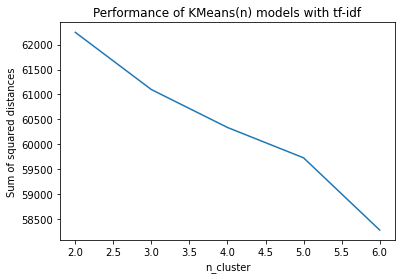

In [14]:
from matplotlib import pyplot as plt

plt.plot([m[0] for m in models_tf_100], [m[1].inertia_ for m in models_tf_100])
plt.xlabel('n_cluster')
plt.ylabel('Sum of squared distances')
plt.title('Performance of KMeans(n) models with tf-idf')
plt.show()

Also we can visualize the clustering results using decomposition methods.

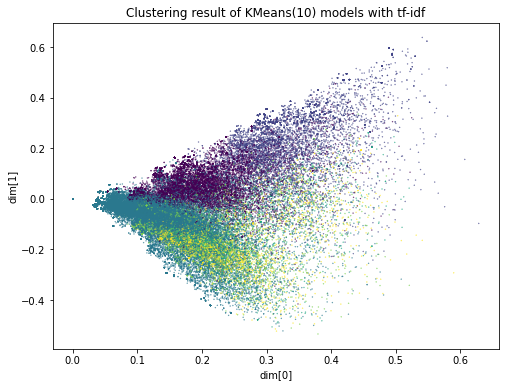

In [15]:
decomp = TruncatedSVD(n_components=3, random_state=501)
dtm_tfv_100_2d = decomp.fit_transform(dtm_tfv_100)
plt.figure(figsize=(8,6))
plt.scatter(dtm_tfv_100_2d[:, 0], dtm_tfv_100_2d[:, 1], s=0.11, c=models_tf_100[-1][1].labels_)
plt.xlabel('dim[0]')
plt.ylabel('dim[1]')
plt.title('Clustering result of KMeans(10) models with tf-idf')
plt.show()

Print Top20 words in each cluster.

In [16]:
m = models_tf_100[-1][1]
for i in range(m.n_clusters):
    center = m.cluster_centers_[i].argsort()[::-1]
    top20 = [tfv_100.get_feature_names()[idx] for idx in center[:20]]
    print('\t', f'Cluster{i}: ', ','.join(top20))

	 Cluster0:  linu,video,riley,tech,watch,news,love,guy,techlink,intel,time,madison,ad,channel,host,amd,make,good,anthoni,know
	 Cluster1:  like,look,sound,linu,feel,video,riley,make,realli,guy,peopl,know,say,good,thing,time,someth,new,tech,news
	 Cluster2:  make,peopl,amd,know,new,time,want,buy,good,appl,nvidia,gpu,say,need,think,thing,year,intel,lol,wait
	 Cluster3:  use,like,peopl,phone,make,appl,time,gpu,googl,amd,want,thing,intel,work,know,actual,need,year,new,nvidia
	 Cluster4:  card,realli,nvidia,amd,buy,new,rtx,price,make,gpu,good,want,need,like,actual,seri,peopl,look,releas,intel
	 Cluster5:  game,play,pc,like,buy,make,use,xbox,run,new,want,good,gpu,need,peopl,year,intel,time,video,nvidia


Most comments are in cluster 0, But the result seems better than CountVectorizer. Let's try some other models.

Before we use DBScan model, it's better to use a small subset and estimate the eps first.

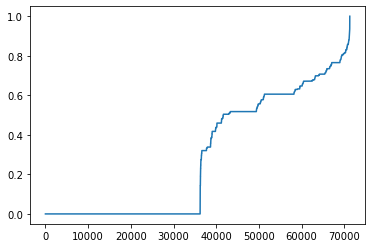

In [17]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


decomp = TruncatedSVD(n_components=3, random_state=501)
dtm_db_3d = decomp.fit_transform(dtm_cv_100)

nn = NearestNeighbors(n_neighbors=2)
nn.fit(dtm_cv_100)
distances, indices = nn.kneighbors(dtm_cv_100)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Fitted DBScan with tf-idf, time elapsed: 71.60s.


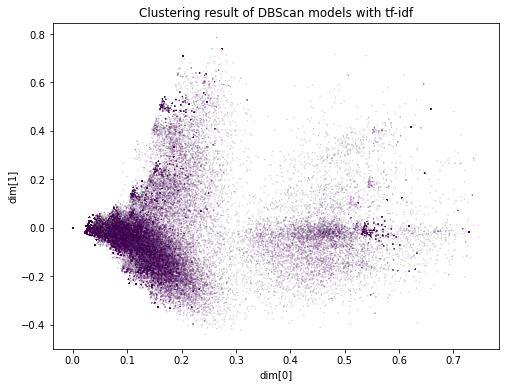

 0      41499
-1      20892
 1       6047
 9         52
 14        20
        ...  
 107        3
 361        3
 208        3
 332        3
 331        2
Length: 391, dtype: int64

In [18]:
t = time.time()
db = DBSCAN(eps=.58, min_samples=5, metric='euclidean', n_jobs=-1)
db.fit(dtm_tfv_100)
print(f'Fitted DBScan with tf-idf, time elapsed: {time.time() - t:.2f}s.')
plt.figure(figsize=(8,6))
plt.scatter(dtm_db_3d[:, 0], dtm_db_3d[:, 2], s=0.01, c=db.labels_)
plt.xlabel('dim[0]')
plt.ylabel('dim[1]')
plt.title('Clustering result of DBScan models with tf-idf')
plt.show()
pd.Series(db.labels_).value_counts()

In [19]:
t = time.time()
hc = AgglomerativeClustering(n_clusters=10, linkage='single')
hc.fit(dtm_cv_100.toarray())
print(f'Fitted hierarchical clustering with tf-idf, time elapsed: {time.time() - t:.2f}s.')

Fitted hierarchical clustering with tf-idf, time elapsed: 250.65s.


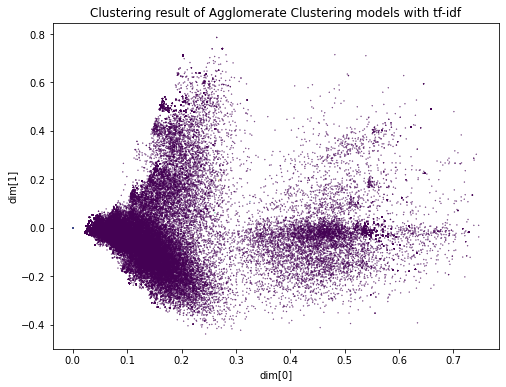

In [20]:
d3 = decomp.transform(dtm_cv_100.toarray())
plt.figure(figsize=(8,6))
plt.scatter(d3[:, 0], d3[:, 2], s=0.11, c=hc.labels_)
plt.xlabel('dim[0]')
plt.ylabel('dim[1]')
plt.title('Clustering result of Agglomerate Clustering models with tf-idf')
plt.show()